In [1]:
!hostname

# Model Loading
from transformers import LlamaForCausalLM, LlamaTokenizer, GenerationConfig
import transformers
import torch
torch.set_grad_enabled(False)

path="/gpfs/share/home/2201110046/LLM/llama_hf/13b"

tokenizer = LlamaTokenizer.from_pretrained(path, padding_side='left')
tokenizer.pad_token = tokenizer.eos_token

model = LlamaForCausalLM.from_pretrained(path, device_map="cuda", load_in_8bit=True)

gpua800n06


/gpfs/share/home/2201110046/.conda/llama/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues


/gpfs/share/home/2201110046/.conda/llama/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:147: UserWarning: /gpfs/share/software/anaconda/3-2023.09-0 did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)


CUDA SETUP: CUDA runtime path found: /gpfs/share/home/2201110046/local_cuda/cuda-11.8/targets/x86_64-linux/lib/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /gpfs/share/home/2201110046/.conda/llama/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda118.so...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]/gpfs/share/home/2201110046/.conda/llama/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Loading checkpoint shards: 100%|██████████| 3/3 [01:15<00:00, 25.06s/it]


In [48]:
import torch

def print_gpu_memory():
    if torch.cuda.is_available():
        print(f"Number of GPUs: {torch.cuda.device_count()}")
        for i in range(torch.cuda.device_count()):
            print(f"\nGPU {i}:")
            gpu_props = torch.cuda.get_device_properties(i)
            print(f"Total Memory: {gpu_props.total_memory / 1024**3:.2f} GB")
            print(f"Memory Allocated: {torch.cuda.memory_allocated(i) / 1024**3:.2f} GB")
            print(f"Memory Reserved: {torch.cuda.memory_reserved(i) / 1024**3:.2f} GB")
    else:
        print("CUDA is not available.")

print_gpu_memory()

!nvidia-smi

Number of GPUs: 1

GPU 0:
Total Memory: 79.33 GB
Memory Allocated: 32.21 GB
Memory Reserved: 49.76 GB
Mon Feb 19 22:56:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A800-SXM4-80GB          Off | 00000000:26:00.0 Off |                    0 |
| N/A   33C    P0              70W / 400W |  51481MiB / 81920MiB |      0%      Default |
|                                         |             

In [62]:
import importlib
from tools import inference
importlib.reload(inference)
from tools import utils
importlib.reload(utils)

<module 'tools.utils' from '/gpfs/share/home/2201110046/LLM/tools/utils.py'>

In [ ]:
from tools.inference import forward, modified_forward
from tools.utils import show_outputs, extract_hidden, extract_hidden_list
from tools.task_generation import gen_task
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


def break2tokens(tokenizer, promtp: str):
    inputs = tokenizer(promtp, return_tensors="pt", padding=True)
    
    task_list=[]
    for ss in inputs["input_ids"]:
        token_list=[]
        for s in ss.tolist():
            output = tokenizer.decode(s)
            token_list.append(output)
        task_list.append(token_list)
    return task_list

def find_last(my_lists):
    element_to_find = '<0x0A>'
    index_list=[]

    for my_list in my_lists:
        if element_to_find in my_list:
            reversed_index = my_list[::-1].index(element_to_find)
            original_index = len(my_list) - 1 - reversed_index
            index_list.append(original_index)
        else:
            index_list.append(1)
    return np.array(index_list)

batch_size = 200
task_train=gen_task(prompt_num=batch_size, example_num=5, same_task=False, seed=0)
prompts_train=task_train.few_shot[0]
target_pos_train=find_last(break2tokens(tokenizer,prompts_train))

task = gen_task(prompt_num=100, example_num=5, same_task=False, seed=1)
prompts = task.few_shot[0]
prompts_lens=['cat->cat\nsad->sad\nA->A\nx->' for _ in range(len(prompts))]
target_pos = find_last(break2tokens(tokenizer,prompts))
answers = []
token_lists = break2tokens(tokenizer, prompts)
for i, _ in enumerate(break2tokens(tokenizer,prompts)):
    answers.append(token_lists[i][target_pos[i]+1])

outputs_train=forward(model, tokenizer, prompts_train, with_hiddens=True)

# Record=np.zeros((40,40))

for target_layer_id in range(16,24):
    # target_layer_id=8

    outputs = forward(model, tokenizer, prompts, with_hiddens=True)
    hiddens_target = extract_hidden_list(outputs, target_layer_id, token_pos_list=target_pos+1)
    outputs = modified_forward(model, tokenizer, prompts_lens, hiddens_target, target_layer_id, token_pos=-2, gen_len=1)
    result = show_outputs(tokenizer, outputs, without_prompt=prompts_lens)

    for layer_id in range(target_layer_id,40):
        source_layer_id=layer_id

        hiddens_source_train=extract_hidden_list(outputs_train, source_layer_id, token_pos_list=target_pos_train+1)
        X_train=hiddens_source_train.cpu().numpy()
        hiddens_target_train=extract_hidden_list(outputs_train, target_layer_id, token_pos_list=target_pos_train+1)
        Y_train=hiddens_target_train.cpu().numpy()

        ln_reg = LinearRegression()
        ln_reg.fit(X_train, Y_train)

        outputs = forward(model, tokenizer, prompts, with_hiddens=True)
        hiddens = extract_hidden_list(outputs, source_layer_id, token_pos_list=target_pos+1)

        target_pred = ln_reg.predict(hiddens.cpu().numpy())
        hiddens_target_pred = torch.tensor(target_pred, dtype=torch.float16).to("cuda")

        outputs_re = modified_forward(model, tokenizer, prompts_lens, hiddens_target_pred, target_layer_id, token_pos=-2, gen_len=1)
        result_re = show_outputs(tokenizer, outputs_re, without_prompt=prompts_lens)

        print(f"source layer {source_layer_id:02d}, target layer {target_layer_id:02d}, original {(np.array(result)==np.array(answers)).sum()}%, recover {(np.array(result_re)==np.array(answers)).sum()}%")
        Record[source_layer_id, target_layer_id]=(np.array(result_re)==np.array(answers)).sum()

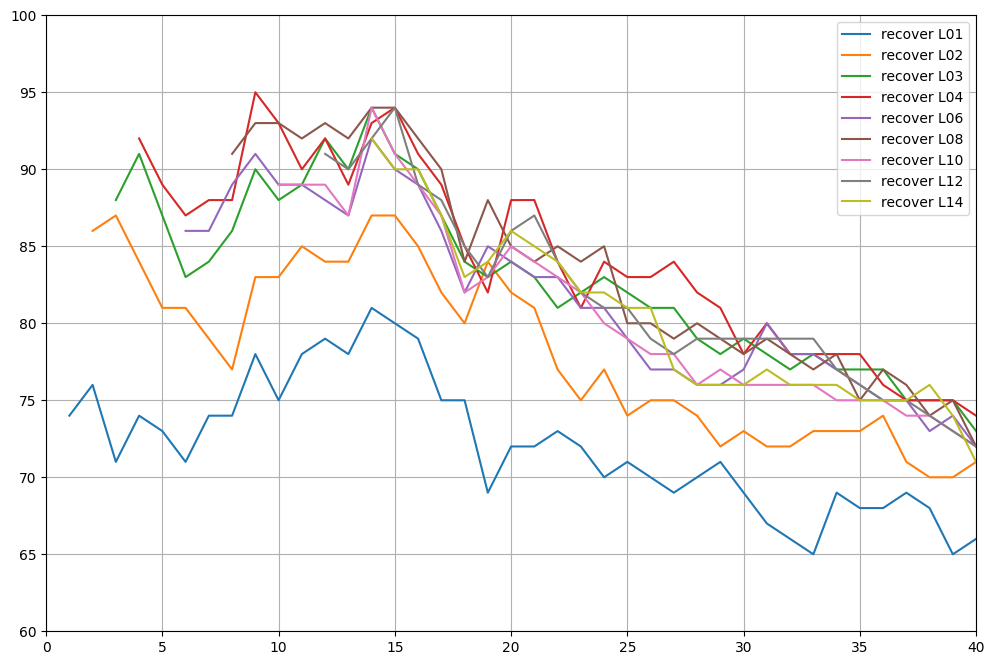

In [89]:
import numpy as np
import matplotlib.pyplot as plt

# Plots
# record=record+[0 for _ in range(16)]
plt.figure(figsize=(12, 8))

for target_layer_id in [0,1,2,3,5,7,9,11,13]:
    plt.plot(np.linspace(target_layer_id+1,40,40-target_layer_id), Record[target_layer_id:, target_layer_id], label=f"recover L{target_layer_id+1:02d}")

plt.xlim([0,40])
plt.ylim([60,100])
plt.grid("True")
plt.legend(loc=1)

plt.show()

In [76]:
Record=np.load("recover_result.npy")
# np.save("recover_result.npy",Record)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Plots

batch_size = 200
task_train=gen_task(prompt_num=batch_size, example_num=5, same_task=False, seed=0)
prompts_train=task_train.few_shot[0]
target_pos_train=find_last(break2tokens(tokenizer,prompts_train))

task = gen_task(prompt_num=100, example_num=5, same_task=False, seed=1)
prompts = task.few_shot[0]
prompts_lens=['cat->cat\nsad->sad\nA->A\nx->' for _ in range(len(prompts))]
target_pos = find_last(break2tokens(tokenizer,prompts))
answers = []
token_lists = break2tokens(tokenizer, prompts)
for i, _ in enumerate(break2tokens(tokenizer,prompts)):
    answers.append(token_lists[i][target_pos[i]+1])

outputs_train=forward(model, tokenizer, prompts_train, with_hiddens=True)

record=[]
for target_layer_id in range(40):
    outputs = forward(model, tokenizer, prompts, with_hiddens=True)
    hiddens_target = extract_hidden_list(outputs, target_layer_id, token_pos_list=target_pos+1)
    outputs = modified_forward(model, tokenizer, prompts_lens, hiddens_target, target_layer_id, token_pos=-2, gen_len=1)
    result = show_outputs(tokenizer, outputs, without_prompt=prompts_lens)
    print(f"target layer {target_layer_id:02d}, original {(np.array(result)==np.array(answers)).sum()}%")
    record.append((np.array(result)==np.array(answers)).sum())

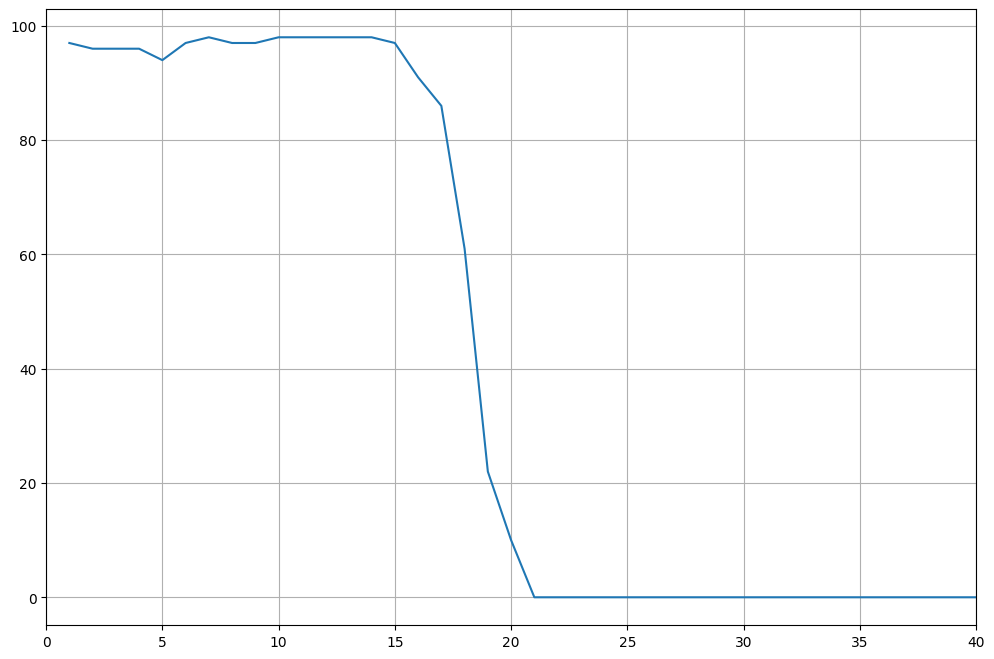

In [90]:
plt.figure(figsize=(12, 8))
plt.plot(np.linspace(1,40,40), record)
plt.grid(True)
plt.xlim([0,40])
plt.show()

In [62]:
import numpy as np

def break2tokens(tokenizer, promtp: str):
    token_list=[]
    inputs = tokenizer(promtp, return_tensors="pt", padding=True)
    
    for s in inputs["input_ids"][0].tolist():
        output = tokenizer.decode(s)
        token_list.append(output)
    return token_list

print(break2tokens(tokenizer,'récit'))

['<s>', 'ré', 'cit']


In [ ]:
# from tools.inference import forward, modified_forward
# from tools.utils import extract_hidden, show_outputs

# target_layer_id=14

# prompts_raw=["boire->" for _ in range(10)]
# hiddens=torch.tensor(ln_model.predict(data[10:10+10,:]))
# # hiddens=torch.tensor(data_y[10:10+10,:])
# outputs_re=modified_forward(model, tokenizer, prompts_raw, target_layer_id, hiddens, gen_len=2)
# print(repr(show_outputs(tokenizer, outputs_re, without_prompt=prompts_raw)))

# prompts_raw=["tavolo->" for _ in range(10)]
# hiddens=torch.tensor(ln_model.predict(data[110:110+10,:]))
# # hiddens=torch.tensor(data_y[110:110+10,:])
# outputs_re=modified_forward(model, tokenizer, prompts_raw, target_layer_id, hiddens, gen_len=2)
# print(repr(show_outputs(tokenizer, outputs_re, without_prompt=prompts_raw)))

# prompts_raw=["стул->" for _ in range(10)]
# hiddens=torch.tensor(ln_model.predict(data[210:210+10,:]))
# # hiddens=torch.tensor(data_y[210:210+10,:])
# outputs_re=modified_forward(model, tokenizer, prompts_raw, target_layer_id, hiddens, gen_len=2)
# print(repr(show_outputs(tokenizer, outputs_re, without_prompt=prompts_raw)))

In [ ]:
# from tools.inference import forward, modified_forward
# from tools.utils import show_outputs, extract_hidden
# from tools.prompt_generation import translation_task

# batch_size = 5
# _, _, _, prompts, answers = translation_task(batch_size, 5, same_task=False)
# prompts_raw=["стул->" for _ in range(len(prompts))]
# #fr: chaise
# #sp: silla
# #it: sedia
# #rs: стул

# outputs=forward(model, tokenizer, prompts)
# layer_id = 16
# hiddens = extract_hidden(outputs, layer_id)
# outputs_re=modified_forward(model, tokenizer, prompts_raw, layer_id, hiddens, gen_len=2)

# for index, s in enumerate(show_outputs(tokenizer, outputs_re, without_prompt=prompts_raw)):
#     print(s=="chair")

In [ ]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, accuracy_score
# import numpy as np

# labels = np.repeat(np.arange(3), batch_size)
# X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# lda = LinearDiscriminantAnalysis()
# lda.fit(X_train, y_train)

# y_pred = lda.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# report64 = classification_report(y_test, y_pred, output_dict=True)
# print(f"Train accuracy: {accuracy}")

In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, accuracy_score
# import numpy as np

# labels = np.repeat(np.arange(3), batch_size)
# X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# classifier = LogisticRegression(max_iter=2000)
# classifier.fit(X_train, y_train)

# # y_pred = classifier.predict(X_train)
# # accuracy = accuracy_score(y_train, y_pred)
# # print(f"Train accuracy: {accuracy}")

# y_pred = classifier.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# report64 = classification_report(y_test, y_pred)
# print(report64)

In [ ]:
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error

# X_train, X_test, y_train, y_test = train_test_split(data, data_tv, test_size=0.2, random_state=42)

# ln_model = LinearRegression()
# ln_model.fit(X_train, y_train)
# predictions = ln_model.predict(X_test)
# mse = mean_squared_error(y_test, predictions)

# print("Mean Squared Error:", mse)

In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# import numpy as np

# y_pred = ln_model.predict(X_test)
# data2 = np.concatenate((y_test, y_pred),axis=0)
# pca = PCA(n_components=2)
# pca_result = pca.fit_transform(data2)

# plt.figure(figsize=(12, 8))

# label_list=["fr2en","sp2en","it2en","fr2en","sp2en","it2en"]
# class_size=DATA.size(1)

# plot_num=20

# pca_result_class = pca_result[:len(y_test),:]
# plt.scatter(pca_result_class[:plot_num, 0], pca_result_class[:plot_num, 1], alpha=0.7)
# pca_result_class = pca_result[len(y_test):,:]
# plt.scatter(pca_result_class[:plot_num, 0], pca_result_class[:plot_num, 1], marker='x')

# for i in range(plot_num):
#     dx=pca_result[i+len(y_test), 0]-pca_result[i, 0]
#     dy=pca_result[i+len(y_test), 1]-pca_result[i, 1]
#     plt.arrow(pca_result[i,0], pca_result[i,1], dx, dy, head_width=0.2, head_length=0.3, length_includes_head=True, color='blue')
#     # plt.plot(pca_result[(i,i+len(y_test)), 0], pca_result[(i,i+len(y_test)), 1], color="blue")

# plt.title('PCA')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.show()